# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
#code to ignore warning 
import warnings
warnings.filterwarnings("ignore")

In [2]:
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bloom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bloom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bloom\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bloom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# import packages/libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import joblib
import datetime
import time

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, multioutput
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn import multioutput
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, fbeta_score, make_scorer, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB 
import pickle

# display all the columns
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60) 
pd.set_option('display.max_colwidth', 500)

In [4]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

### Exploratory Data Analysis (EDA) - Portfolio

In [5]:
#look at the first ten rows of data
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
#look at columns and data
print(portfolio.info())
print('---------------------------------')
#count the number of columns and rows
row_col = portfolio.shape
print('Rows, Columns: {}'.format(row_col))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None
---------------------------------
Rows, Columns: (10, 6)


In [7]:
#look for missing values
portfolio.isnull().sum(axis=0) * 100 / portfolio.shape[0]

reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64

In [8]:
#look at the offer_type column
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

### Clean Portfolio DataFrame
- rename columns duration to days_duration, and id to id_offer
- use one hot incode to create dummy columns for channels and offer_type
- drop channels column

In [9]:
#change column names
portfolio.rename(columns = {'duration':'days_duration'}, inplace = True)
portfolio.rename(columns = {'id':'id_offer'}, inplace = True)
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reward         10 non-null     int64 
 1   channels       10 non-null     object
 2   difficulty     10 non-null     int64 
 3   days_duration  10 non-null     int64 
 4   offer_type     10 non-null     object
 5   id_offer       10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [10]:
#one hot encode offer_type
offertype = pd.get_dummies(portfolio['offer_type']).astype(int)

#one hot encode channels
mlb = MultiLabelBinarizer()
mlb.fit(portfolio['channels'])

channels = pd.DataFrame(mlb.transform(portfolio['channels']), columns = mlb.classes_).astype(int)

#add the new columns
portfolio = pd.concat([portfolio, offertype, channels], axis=1)

portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reward         10 non-null     int64 
 1   channels       10 non-null     object
 2   difficulty     10 non-null     int64 
 3   days_duration  10 non-null     int64 
 4   offer_type     10 non-null     object
 5   id_offer       10 non-null     object
 6   bogo           10 non-null     int32 
 7   discount       10 non-null     int32 
 8   informational  10 non-null     int32 
 9   email          10 non-null     int32 
 10  mobile         10 non-null     int32 
 11  social         10 non-null     int32 
 12  web            10 non-null     int32 
dtypes: int32(7), int64(3), object(3)
memory usage: 888.0+ bytes


In [11]:
portfolio.drop('channels', axis = 1, inplace = True)

In [12]:
#reorder columns
col_reorder = ['id_offer',
             'difficulty',
             'days_duration',
             'offer_type',
             'bogo',
             'discount',
             'informational',
             'email',
             'mobile',
             'social',
             'web']
portfolio = portfolio[col_reorder]
portfolio.head()

,id_offer,difficulty,days_duration,offer_type,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,0,1,0,1,0,0,1


### EDA - Profile

In [13]:
#look at the first five rows of data
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
#look at columns and data
print(profile.info())
print('---------------------------------')
#count the number of columns and rows
row_col = profile.shape
print('Rows, Columns: {}'.format(row_col))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None
---------------------------------
Rows, Columns: (17000, 5)


In [15]:
prof_null = profile.isnull().sum(axis=0)
print('Number of Null Values for Profile Columns')
print(prof_null)

Number of Null Values for Profile Columns
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [16]:
#determine which columns are numerical and categorical
# Subset to a dataframe only holding the quantitative columns
num_profile = profile.select_dtypes(include=['int64', 'float64']).copy()
# Subset to a dataframe only holding the categorical columns
cat_profile = profile.select_dtypes(include=['object']).copy()


# Print how many numerical and categorical columns are in the dataframe
print("Total Numerical Columns:  {}".format(num_profile.shape[1]))
print('--------------------------------')
print("Total Categorical Columns:  {}".format(cat_profile.shape[1]))

Total Numerical Columns:  3
--------------------------------
Total Categorical Columns:  2


### Clean Profile DataFrame
 - rename column id to id_person
 - create dt_membership as type date, then drop became_member_on
 - create yr_membership column as type int
 - drop records where age = 118
 - drop records where gender = 'O'
 - create gender_binary column  
 - remove columns with missing income
 - create age range column (age_range)
 - create dummy variables from age_range column

In [17]:
# rename id to id_person
profile.rename(columns = {'id':'id_person'}, inplace = True)

In [18]:
#create datetime column 
profile['dt_membership'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
#drop old column
del profile['became_member_on']
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   gender         14825 non-null  object        
 1   age            17000 non-null  int64         
 2   id_person      17000 non-null  object        
 3   income         14825 non-null  float64       
 4   dt_membership  17000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


In [19]:
#create yr_membership column
profile['yr_membership'] = profile['dt_membership'].dt.strftime('%Y').astype('int64')
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   gender         14825 non-null  object        
 1   age            17000 non-null  int64         
 2   id_person      17000 non-null  object        
 3   income         14825 non-null  float64       
 4   dt_membership  17000 non-null  datetime64[ns]
 5   yr_membership  17000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 797.0+ KB


In [20]:
#remove records where age = 118
profile['age'] = profile['age'].where(profile.age != 118).dropna(axis=0)
profile.head()

,gender,age,id_person,income,dt_membership,yr_membership
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,2017
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,2018
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,2017


In [21]:
#look at the values for gender
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [22]:
#remove rows with missing income and gender = 'O'
profile = profile[profile['income'].notnull()]
profile = profile[profile['gender'] != 'O']
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 1 to 16999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   gender         14613 non-null  object        
 1   age            14613 non-null  float64       
 2   id_person      14613 non-null  object        
 3   income         14613 non-null  float64       
 4   dt_membership  14613 non-null  datetime64[ns]
 5   yr_membership  14613 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 799.1+ KB


In [23]:
#create gender binary column
gender = {'M':1,'F':0}
profile['gender_binary'] = [gender[x] for x in profile.gender]
profile.gender_binary.value_counts()

1    8484
0    6129
Name: gender_binary, dtype: int64

In [24]:
#reorder columns
col_reorder = ['id_person',
             'gender',
             'age',
             'income',
             'dt_membership',
             'yr_membership',
             'gender_binary']
profile = profile[col_reorder]
profile.head()

,id_person,gender,age,income,dt_membership,yr_membership,gender_binary
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,112000.0,2017-07-15,2017,0
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,100000.0,2017-05-09,2017,0
5,e2127556f4f64592b11af22de27a7932,M,68.0,70000.0,2018-04-26,2018,1
8,389bc3fa690240e798340f5a15918d5c,M,65.0,53000.0,2018-02-09,2018,1
12,2eeac8d8feae4a8cad5a6af0499a211d,M,58.0,51000.0,2017-11-11,2017,1


In [25]:
profile.describe()

,age,income,yr_membership,gender_binary
count,14613.000000,14613.000000,14613.000000,14613.000000
mean,54.393417,65435.707931,2016.618696,0.580579
std,17.400201,21633.524110,1.199147,0.493481
min,18.000000,30000.000000,2013.000000,0.000000
25%,42.000000,49000.000000,2016.000000,0.000000
50%,55.000000,64000.000000,2017.000000,1.000000
75%,66.000000,80000.000000,2017.000000,1.000000
max,101.000000,120000.000000,2018.000000,1.000000


In [26]:
profile.yr_membership.value_counts()

2017    5510
2018    3614
2016    2992
2015    1568
2014     658
2013     271
Name: yr_membership, dtype: int64

In [27]:
#create age_range column
age_range = []

for row in profile.age:
    if row in range(18,25):
        age_range.append('18-24')
    elif row in range(24,45):            
        age_range.append('25-44')
    elif row in range(45,65):
        age_range.append('45-64')
    elif row in range(65,85):
        age_range.append('65-84')
    elif row in range(0):
        age_range.append('Unknown')
    else:
        age_range.append('85+')                
profile['age_range'] = age_range  

In [28]:
profile.age_range.value_counts()

45-64    6335
65-84    3637
25-44    3202
18-24     867
85+       572
Name: age_range, dtype: int64

In [29]:
#Create dummy columns for age range
#one hot encode offer_type
agerange = pd.get_dummies(profile['age_range']).astype(int)

#add the new columns
profile = pd.concat([profile, agerange], axis=1)

profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 1 to 16999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_person      14613 non-null  object        
 1   gender         14613 non-null  object        
 2   age            14613 non-null  float64       
 3   income         14613 non-null  float64       
 4   dt_membership  14613 non-null  datetime64[ns]
 5   yr_membership  14613 non-null  int64         
 6   gender_binary  14613 non-null  int64         
 7   age_range      14613 non-null  object        
 8   18-24          14613 non-null  int32         
 9   25-44          14613 non-null  int32         
 10  45-64          14613 non-null  int32         
 11  65-84          14613 non-null  int32         
 12  85+            14613 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(5), int64(2), object(3)
memory usage: 1.3+ MB


#### Visualize profile

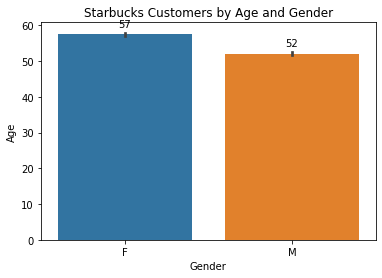

In [30]:
#bar plot by age and gender
df_copy = profile.copy()

df_copy = sns.barplot(data=df_copy, 
                      x="gender", 
                      y="age")

for p in df_copy.patches:
    df_copy.annotate(str(int(p.get_height())), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', 
                     va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points')    

    
plt.title('Starbucks Customers by Age and Gender')
plt.xlabel('Gender')
plt.ylabel('Age');

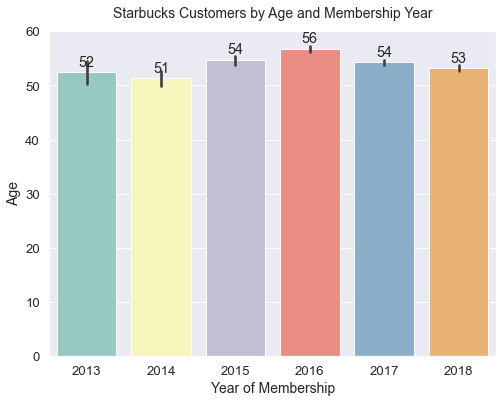

In [31]:
#bar plot by age and year

df_copy = profile.copy().dropna()

years = [2013, 2014, 2015, 2016, 2017, 2018]

sns.set(style='darkgrid', 
        font_scale=1.2)

plt.figure(figsize=(8, 6))

df_copy=sns.barplot(x="yr_membership",
                    y="age",
                    data=df_copy,
                    order=years,
                    palette='Set3')

for p in df_copy.patches:
    df_copy.annotate(str(int(p.get_height())), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', 
                     va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points')    

plt.title("Starbucks Customers by Age and Membership Year", y=1.02, fontsize=14)
plt.xlabel("Year of Membership", size=14)
plt.ylabel("Age", size=14)
plt.show();

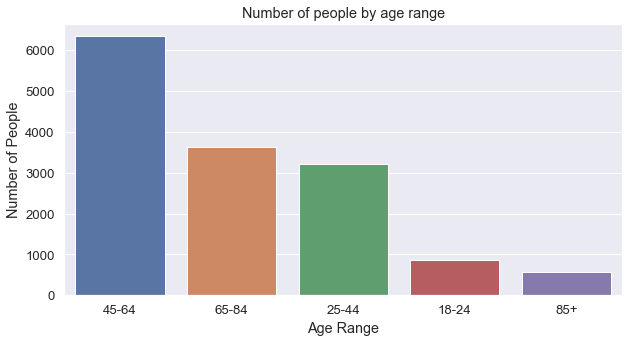

In [32]:
#plot the number of people by age range
df_copy = profile.copy().dropna()

ax = plt.figure(figsize=(10,5))
sns.set(style='darkgrid', font_scale=1.2)
ax = sns.countplot(x='age_range', data=df_copy).set_title('Number of people by age range')
ax = plt.ylabel('Number of People')
ax = plt.xlabel('Age Range')

The age range with the highest number of customers is 45-64, followed by
 - 65-84
 - 25-44
 - 18-24
 - 85+

### EDA - Transcripts

In [33]:
#look at the first five rows of data
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [34]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [35]:
#look at columns and data
print(transcript.info())
print('---------------------------------')
#count the number of columns and rows
row_col = transcript.shape
print('Rows, Columns: {}'.format(row_col))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
---------------------------------
Rows, Columns: (306534, 4)


In [36]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [37]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
print('Event Counts')
print(event_counts)
print('------------------------')
print('Total:')
print(event_counts['count'].sum())

Event Counts
             event   count
0      transaction  138953
1   offer received   76277
2     offer viewed   57725
3  offer completed   33579
------------------------
Total:
306534


In [38]:
#look for missing values
transcript.isnull().sum(axis=0) * 100 / transcript.shape[0]

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

### Clean transcript DataFrame
 - rename column person to id
 - create new colum days_time
 - remove an id if it is not part of the profile df
 - create column id_offer to join later
 - reorder colums to have id_person and id_offer the first two columns
 - create dummy columns from event
 - create a DataFrame with the transaction data

In [39]:
# rename person to id_person
transcript.rename(columns = {'person':'id_person'}, inplace = True)

In [40]:
#create a new column for days
transcript['days_time'] = transcript['time'] // 24.0
transcript.head()

,id_person,event,value,time,days_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0


In [41]:
# remove an id if it is not part of the profile df
remove_ids = transcript['id_person'].isin(profile['id_person'])
transcript = transcript[remove_ids]
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268791 entries, 0 to 306532
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id_person  268791 non-null  object
 1   event      268791 non-null  object
 2   value      268791 non-null  object
 3   time       268791 non-null  int64 
 4   days_time  268791 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 12.3+ MB


In [42]:
#Create id_offer to join later
event_offer1 = re.compile('^offer (?:received|viewed|completed)')
event_offer2 = lambda x: event_offer1.match(x) != None
offers = transcript.event.apply(event_offer2)
transcript['id_offer'] =transcript.value.apply(lambda x: list(x.values())[0])
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268791 entries, 0 to 306532
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id_person  268791 non-null  object
 1   event      268791 non-null  object
 2   value      268791 non-null  object
 3   time       268791 non-null  int64 
 4   days_time  268791 non-null  int64 
 5   id_offer   268791 non-null  object
dtypes: int64(2), object(4)
memory usage: 14.4+ MB


In [43]:
#reorder columns
col_reorder = ['id_person',
             'id_offer',
             'event',
             'value',
             'time',
             'days_time']
transcript = transcript[col_reorder]
transcript.head()

,id_person,id_offer,event,value,time,days_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0


In [44]:
#create dummy columns from event
transcript['event'] = transcript['event'].str.replace(' ', '_')
dummy_col = pd.get_dummies(transcript.event)
transcript = pd.concat([transcript, dummy_col], axis=1,sort=False)
transcript.head()

,id_person,id_offer,event,value,time,days_time,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer_received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer_received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,offer_received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0,1,0,0


In [45]:
#create a dataframe with only transaction data
df_transaction = transcript[transcript.event == 'transaction']
#select transaction related columns 
df_transaction = df_transaction[['id_person', 'id_offer', 'time','days_time']]
#rename id_offer to amount
df_transaction.rename(columns = {'id_offer':'amount'}, inplace = True)
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122176 entries, 12654 to 306532
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id_person  122176 non-null  object
 1   amount     122176 non-null  object
 2   time       122176 non-null  int64 
 3   days_time  122176 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.7+ MB


In [46]:
df_transaction.head()

,id_person,amount,time,days_time
12654,02c083884c7d45b39cc68e1314fec56c,0.83,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,0,0
12659,54890f68699049c2a04d415abc25e717,13.23,0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,19.51,0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,18.97,0,0


In [47]:
#drop value and transaction column
transcript.drop(columns='value', inplace=True)
transcript.drop(columns='transaction', inplace=True)

transcript.head()

,id_person,id_offer,event,time,days_time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_received,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer_received,0,0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer_received,0,0,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,offer_received,0,0,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_received,0,0,0,1,0


In [48]:
transcript['event'].value_counts()

transaction        122176
offer_received      65585
offer_viewed        49087
offer_completed     31943
Name: event, dtype: int64

In [49]:
#Drop event type transaction from transcript DataFrame
transcript = transcript[transcript.event != 'transaction']
transcript['event'].value_counts()

offer_received     65585
offer_viewed       49087
offer_completed    31943
Name: event, dtype: int64

#### Visualize transcript

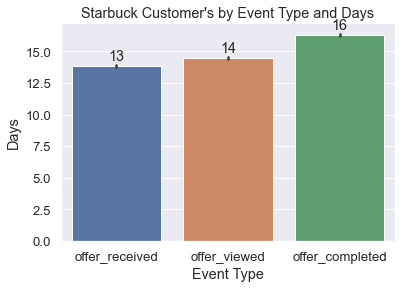

In [50]:
#bar plot by age and membership year
df_copy = transcript.copy().dropna()

df_copy = sns.barplot(data=df_copy, 
                      x="event", 
                      y="days_time")

for p in df_copy.patches:
    df_copy.annotate(str(int(p.get_height())), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', 
                     va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points')    

    
plt.title("Starbuck Customer's by Event Type and Days")
plt.xlabel('Event Type')
plt.ylabel('Days');

In [51]:
transcript.to_csv('transcript.csv')

### EDA Portfolio, Profile, Transcript
 - Combine Portfolio, Profile, and Transcript DataFrames
 - Create age range column (age_range)
 - Drop rows with missing values
 - Continue with EDA

In [52]:
print('Portfolio-------------------------------')
print(portfolio.info())
print('----------------------------------------')
print('Profile---------------------------------')
print(profile.info())
print('----------------------------------------')
print('Transcript------------------------------')
print(transcript.info())

Portfolio-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id_offer       10 non-null     object
 1   difficulty     10 non-null     int64 
 2   days_duration  10 non-null     int64 
 3   offer_type     10 non-null     object
 4   bogo           10 non-null     int32 
 5   discount       10 non-null     int32 
 6   informational  10 non-null     int32 
 7   email          10 non-null     int32 
 8   mobile         10 non-null     int32 
 9   social         10 non-null     int32 
 10  web            10 non-null     int32 
dtypes: int32(7), int64(2), object(2)
memory usage: 728.0+ bytes
None
----------------------------------------
Profile---------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 1 to 16999
Data columns (total 13 columns):
 #   Column         Non-Null Count  D

In [53]:
#create master DataFrame from transcript, profile, and portfolio DataFrame
starbucks_merged = pd.merge(transcript, 
                            profile, 
                            how='left',
                            on='id_person')

starbucks_master = pd.merge(starbucks_merged, 
                            portfolio, 
                            how='left', 
                            on='id_offer')
starbucks_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146615 entries, 0 to 146614
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id_person        146615 non-null  object        
 1   id_offer         146615 non-null  object        
 2   event            146615 non-null  object        
 3   time             146615 non-null  int64         
 4   days_time        146615 non-null  int64         
 5   offer_completed  146615 non-null  uint8         
 6   offer_received   146615 non-null  uint8         
 7   offer_viewed     146615 non-null  uint8         
 8   gender           146615 non-null  object        
 9   age              146615 non-null  float64       
 10  income           146615 non-null  float64       
 11  dt_membership    146615 non-null  datetime64[ns]
 12  yr_membership    146615 non-null  int64         
 13  gender_binary    146615 non-null  int64         
 14  age_range        146

In [54]:
#Convert columns to int64
starbucks_master = starbucks_master.astype({'offer_completed': 'int64',
                                            'offer_received': 'int64',
                                            'offer_viewed': 'int64',
                                            'bogo': 'int64',
                                            'discount': 'int64',
                                            'informational': 'int64',
                                            'email': 'int64',
                                            'mobile': 'int64',
                                            'social': 'int64',
                                            'web': 'int64',
                                            '18-24': 'int64',
                                            '25-44': 'int64',
                                            '45-64': 'int64',
                                            '65-84': 'int64',
                                            '85+': 'int64',
                                           })
starbucks_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146615 entries, 0 to 146614
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id_person        146615 non-null  object        
 1   id_offer         146615 non-null  object        
 2   event            146615 non-null  object        
 3   time             146615 non-null  int64         
 4   days_time        146615 non-null  int64         
 5   offer_completed  146615 non-null  int64         
 6   offer_received   146615 non-null  int64         
 7   offer_viewed     146615 non-null  int64         
 8   gender           146615 non-null  object        
 9   age              146615 non-null  float64       
 10  income           146615 non-null  float64       
 11  dt_membership    146615 non-null  datetime64[ns]
 12  yr_membership    146615 non-null  int64         
 13  gender_binary    146615 non-null  int64         
 14  age_range        146

### Remove duplicates
 - Check how many duplicates are in this dataset.
 - Drop the duplicates (if applicable).
 - Confirm duplicates were removed (if applicable).

In [55]:
#check number of duplicates
sum(starbucks_master.duplicated(starbucks_master.columns))

368

In [56]:
#drop duplicates
starbucks_master = starbucks_master.drop_duplicates()

In [57]:
#check number of duplicates
sum(starbucks_master.duplicated(starbucks_master.columns))

0

In [58]:
starbucks_master.head()

,id_person,id_offer,event,time,days_time,offer_completed,offer_received,offer_viewed,gender,age,income,dt_membership,yr_membership,gender_binary,age_range,18-24,25-44,45-64,65-84,85+,difficulty,days_duration,offer_type,bogo,discount,informational,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_received,0,0,0,1,0,F,75.0,100000.0,2017-05-09,2017,0,65-84,0,0,0,1,0,5,7,bogo,1,0,0,1,1,0,1
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer_received,0,0,0,1,0,M,68.0,70000.0,2018-04-26,2018,1,65-84,0,0,0,1,0,10,7,discount,0,1,0,1,1,0,1
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer_received,0,0,0,1,0,M,65.0,53000.0,2018-02-09,2018,1,65-84,0,0,0,1,0,5,5,bogo,1,0,0,1,1,1,1
3,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,offer_received,0,0,0,1,0,M,58.0,51000.0,2017-11-11,2017,1,45-64,0,0,1,0,0,0,4,informational,0,0,1,1,1,0,1
4,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_received,0,0,0,1,0,F,61.0,57000.0,2017-09-11,2017,0,45-64,0,0,1,0,0,20,10,discount,0,1,0,1,0,0,1


In [59]:
purchase_offer_type = starbucks_master.groupby('offer_type').id_person.nunique()
purchase_offer_type

offer_type
bogo             12900
discount         12857
informational     9070
Name: id_person, dtype: int64

#### Visualize starbucks_master

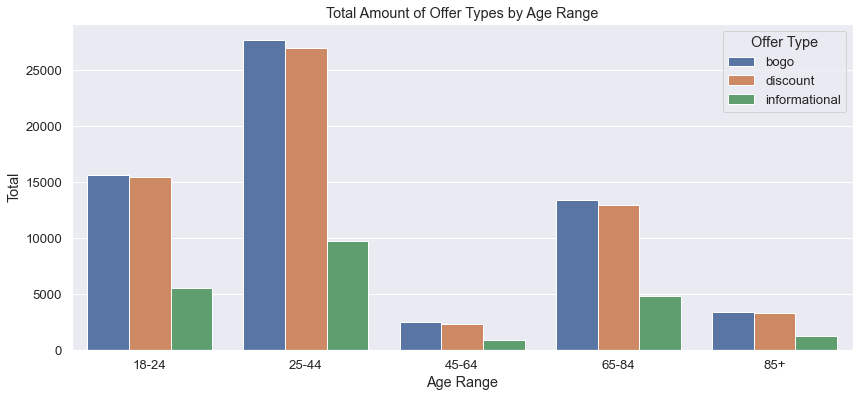

In [60]:
df_copy = starbucks_master.copy()

plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_range", hue="offer_type", data=df_copy)
plt.title('Total Amount of Offer Types by Age Range')
plt.ylabel('Total')
plt.xlabel('Age Range')
xlabels = ['18-24','25-44','45-64','65-84', '85+']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

The age range that recieved the most offer type were age 25-44, followed by:
 - 18-24
 - 65-84
 - 85+
 - 45-64

In [61]:
starbucks_master.to_csv('starbucks_master.csv')
#portfolio.to_csv('portfolio.csv')
#profile.to_csv('profile.csv')
#transcript.to_csv('transcript.csv')

## Machine Learning Pipeline Preparation

### 1. Load data and define feature and target variables X and y

In [62]:
starbucks_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146247 entries, 0 to 146614
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id_person        146247 non-null  object        
 1   id_offer         146247 non-null  object        
 2   event            146247 non-null  object        
 3   time             146247 non-null  int64         
 4   days_time        146247 non-null  int64         
 5   offer_completed  146247 non-null  int64         
 6   offer_received   146247 non-null  int64         
 7   offer_viewed     146247 non-null  int64         
 8   gender           146247 non-null  object        
 9   age              146247 non-null  float64       
 10  income           146247 non-null  float64       
 11  dt_membership    146247 non-null  datetime64[ns]
 12  yr_membership    146247 non-null  int64         
 13  gender_binary    146247 non-null  int64         
 14  age_range        146

In [63]:
#create new df to use for machine learning
starbucks_ml = starbucks_master.copy()
starbucks_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146247 entries, 0 to 146614
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id_person        146247 non-null  object        
 1   id_offer         146247 non-null  object        
 2   event            146247 non-null  object        
 3   time             146247 non-null  int64         
 4   days_time        146247 non-null  int64         
 5   offer_completed  146247 non-null  int64         
 6   offer_received   146247 non-null  int64         
 7   offer_viewed     146247 non-null  int64         
 8   gender           146247 non-null  object        
 9   age              146247 non-null  float64       
 10  income           146247 non-null  float64       
 11  dt_membership    146247 non-null  datetime64[ns]
 12  yr_membership    146247 non-null  int64         
 13  gender_binary    146247 non-null  int64         
 14  age_range        146

In [64]:
starbucks_ml = starbucks_ml[['id_person',
                                  'gender',
                                  'age',
                                  'age_range',
                                  'event',
                                  'offer_type',
                                  '18-24',
                                  '25-44',
                                  '45-64',
                                  '65-84',
                                  '85+',
                                  'bogo',
                                  'discount',
                                  'informational',
                                  'email',
                                  'mobile',
                                  'social',
                                  'web']]
starbucks_ml.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146247 entries, 0 to 146614
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_person      146247 non-null  object 
 1   gender         146247 non-null  object 
 2   age            146247 non-null  float64
 3   age_range      146247 non-null  object 
 4   event          146247 non-null  object 
 5   offer_type     146247 non-null  object 
 6   18-24          146247 non-null  int64  
 7   25-44          146247 non-null  int64  
 8   45-64          146247 non-null  int64  
 9   65-84          146247 non-null  int64  
 10  85+            146247 non-null  int64  
 11  bogo           146247 non-null  int64  
 12  discount       146247 non-null  int64  
 13  informational  146247 non-null  int64  
 14  email          146247 non-null  int64  
 15  mobile         146247 non-null  int64  
 16  social         146247 non-null  int64  
 17  web            146247 non-nul

In [65]:
# create y variable
y = starbucks_ml[starbucks_ml.columns[6:]]
display (y.head())

,18-24,25-44,45-64,65-84,85+,bogo,discount,informational,email,mobile,social,web
0,0,0,0,1,0,1,0,0,1,1,0,1
1,0,0,0,1,0,0,1,0,1,1,0,1
2,0,0,0,1,0,1,0,0,1,1,1,1
3,0,0,1,0,0,0,0,1,1,1,0,1
4,0,0,1,0,0,0,1,0,1,0,0,1


In [66]:
# look at the columns, non-null counts, and data types
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146247 entries, 0 to 146614
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   18-24          146247 non-null  int64
 1   25-44          146247 non-null  int64
 2   45-64          146247 non-null  int64
 3   65-84          146247 non-null  int64
 4   85+            146247 non-null  int64
 5   bogo           146247 non-null  int64
 6   discount       146247 non-null  int64
 7   informational  146247 non-null  int64
 8   email          146247 non-null  int64
 9   mobile         146247 non-null  int64
 10  social         146247 non-null  int64
 11  web            146247 non-null  int64
dtypes: int64(12)
memory usage: 14.5 MB


In [67]:
# create X variable
X = starbucks_ml['event']

In [68]:
# look at the counts by offer type
X.value_counts()

offer_received     65585
offer_viewed       49087
offer_completed    31575
Name: event, dtype: int64

In [69]:
print(X.shape)
print(y.shape)

(146247,)
(146247, 12)


In [70]:
#check for missing values
X.isnull().sum()

0

In [71]:
#check for missing values
y.isnull().sum()

18-24            0
25-44            0
45-64            0
65-84            0
85+              0
bogo             0
discount         0
informational    0
email            0
mobile           0
social           0
web              0
dtype: int64

### 2a. Write a tokenization function to process your text data

In [72]:
def tokenize(text):
    """Tokenization function. Receives as input raw text which afterwards normalized, 
    stop words removed, stemmed and lemmatized.
    Returns tokenized text"""
    
    # Normalize text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    stop_words = stopwords.words("english")
    
    #tokenize
    words = word_tokenize(text)
    
    #stemming
    stemmed = [PorterStemmer().stem(w) for w in words]
    
    #lemmatizing
    words_lemmed = [WordNetLemmatizer().lemmatize(w) for w in stemmed if w not in stop_words]
   
    return words_lemmed

### 2b. Additional functions

In [73]:
def f1_pre_acc_evaluation (y_true, y_pred): 
    """A function that measures mean of f1, precision, recall for each class within multi-class prediction 
       Returns a dataframe with columns: 
       f1-score (average for all possible values of specific class)
       precision (average for all possible values of specific class)
       recall (average for all possible values of specific class)
       kindly keep in mind that some classes might be imbalanced and average values may mislead. 
    """
    #instantiating a dataframe
    report = pd.DataFrame ()
    
    for col in y_true.columns:
        #returning dictionary from classification report
        class_dict = classification_report (output_dict = True, y_true = y_true.loc [:,col], y_pred = y_pred.loc [:,col])
    
        #converting from dictionary to dataframe
        eval_df = pd.DataFrame (pd.DataFrame.from_dict (class_dict))
        
        #calculating mean values
        av_eval_df = pd.DataFrame (eval_df.transpose ().mean ())
        
        #transposing columns to rows and vice versa 
        av_eval_df = av_eval_df.transpose ()
    
        #appending result to report df
        report = report.append (av_eval_df, ignore_index = True)    
    
    #renaming indexes for convinience
    report.index = y_true.columns
    
    return report

def f1_scorer_eval (y_true, y_pred): 
    """A function that measures mean of F1 for all classes 
       Returns an average value of F1 for sake of evaluation whether model predicts better or worse in GridSearchCV 
    """
    #converting y_pred from np.array to pd.dataframe
    #keep in mind that y_pred should a pd.dataframe rather than np.array
    y_pred = pd.DataFrame (y_pred, columns = y_true.columns)
    
    
    #instantiating a dataframe
    report = pd.DataFrame ()
    
    for col in y_true.columns:
        #returning dictionary from classification report
        class_dict = classification_report (output_dict = True, y_true = y_true.loc [:,col], y_pred = y_pred.loc [:,col])
    
        #converting from dictionary to dataframe
        eval_df = pd.DataFrame (pd.DataFrame.from_dict (class_dict))
        
        #calculating mean values
        av_eval_df = pd.DataFrame (eval_df.transpose ().mean ())
        
        #transposing columns to rows and vice versa 
        av_eval_df = av_eval_df.transpose ()
    
        #appending result to report df
        report = report.append (av_eval_df, ignore_index = True)    
    
    #returining mean value for all classes. since it's used for GridSearch we may use mean
    #as the overall value of F1 should grow. 
    return report ['f1-score'].mean ()

### 3. Build a machine learning pipeline
This machine pipeline takes in the `event` column as input and output results on the categories in the dataset. 

In [74]:
pipeline = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf',MultiOutputClassifier(RandomForestClassifier())),
    ])

In [75]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__bootstrap', 'clf__estimator__ccp_alpha', 'clf__estimator__class_weight', 'clf__estimator__criterion', 'clf__estimator__max_depth', 'clf__estimator__max_features', 'clf__estimator__max_leaf_nodes', 'clf__estimator__max_samples', 'clf__estimator__min_impurity_decrease', 'clf__estimator__min_impurity_split', 'clf__estimator__min_samples_leaf', 'clf__estimator__min_samples_split', 'clf__estimator__min_weight_fraction_leaf', 'clf__estimator__n_estimators', 'clf__estimator__n_jobs', 'clf__estimator__oob_score', 'clf_

### 4. Train pipeline
 - Split data into train and test sets
 - Train pipeline

In [76]:
# train pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y)
# train classifier
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000001FA7E8BD820>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test model
Report the precision, recall, f1-score, and support for each output category of the dataset. 
 - **Precision** is how precise/accurate your model is out of those predicted positive, how many of them are actual positive
 - **Recall** is how many of the Actual Positives our model capture through labeling it as Positive (True Positive)
 - **F1 Score** is a function of precision and recall. Seeks a balance between Precision and Recall and when there is an uneven class distribution (large number of acutal negatives).

In [77]:
y_pred = pipeline.predict(X_test)
#converting to dataframe
y_pred = pd.DataFrame(y_pred, columns = y_test.columns)

In [78]:
#Test using function f1_pre_acc_evaluation
report = f1_pre_acc_evaluation(y_test, y_pred)
report

,precision,recall,f1-score,support
18-24,0.650791,0.677857,0.663938,21937.388928
25-44,0.517612,0.614917,0.560475,21937.357459
45-64,0.338890,0.521881,0.404179,21937.310940
65-84,0.489503,0.601001,0.537379,21937.350501
85+,0.665081,0.684344,0.674521,21937.392172
bogo,0.349973,0.527996,0.414605,21937.313998
discount,0.576759,0.567036,0.549106,21937.318921
informational,0.567509,0.639051,0.600330,21937.369526
email,1.000000,1.000000,1.000000,27421.750000
mobile,0.626622,0.666774,0.645828,21937.383387


For the age range indicators, the highest F1 Score was over 85 (.67) followed by:
 - 18-24 (.66)
 - 25-44 (.56)
 - 65-84 (.53)
 - 45-64 (.41)
<br><br>
For the event indicators, the highest F1 Score was informational (.60) followed by:
 - discount (.55)
 - bogo (.41)
<br><br>
For the channels indicators, the highest F1 Score was email (1.00) followed by:
 - mobile (.64)
 - web (.57) 
 - social (.48) 

### 6. Improved model
Use grid search to find better parameters. 

In [79]:
# fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_scorer_eval)

parameters = {
    'vect__max_df': (0.75, 1.0),
    'clf__estimator__n_estimators': [10, 20],
    'clf__estimator__min_samples_split': [2, 5]
}
cv_improved = GridSearchCV(pipeline, param_grid= parameters, scoring = scorer, verbose =7)
cv_improved

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x000001FA7E8BD820>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__min_samples_split': [2, 5],
                         'clf__estimator__n_estimators': [10, 20],
                         'vect__max_df': (0.75, 1.0)},
             scoring=make_scorer(f1_scorer_eval), verbose=7)

In [80]:
# look at the parameters
cv_improved.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001FA7E8BD820>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'estimator__verbose': False,
 'estimator__vect': CountVectorizer(tokenizer=<function tokenize at 0x000001FA7E8BD820>),
 'estimator__tfidf': TfidfTransformer(),
 'estimator__clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'estimator__vect__analyzer': 'word',
 'estimator__vect__binary': False,
 'estimator__vect__decode_error': 'strict',
 'estimator__vect__dtype': numpy.int64,
 'estimator__vect__encoding': 'utf-8',
 'estimator__vect__input': 'content',
 'estimator__vect__lowercase': True,
 'estimator__vect__max_df': 1.0,
 'estimator__vect__max_features': None,
 'estimator__vect__min_df': 1,
 'estimator__vect__ngram_range': (1, 1),
 'estimator__vect__preprocessor': None,
 'estimator__vect__stop_words': No

In [81]:
# train classifier
cv_improved.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75;, score=0.592 total time= 2.7min
[CV 2/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75;, score=0.592 total time= 2.6min
[CV 3/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75;, score=0.592 total time= 2.2min
[CV 4/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75;, score=0.591 total time= 2.5min
[CV 5/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75;, score=0.591 total time= 2.3min
[CV 1/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=1.0;, score=0.592 total time= 2.3min
[CV 2/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=1.0;, score=0.592 total time= 2.3min
[CV 

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x000001FA7E8BD820>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__min_samples_split': [2, 5],
                         'clf__estimator__n_estimators': [10, 20],
                         'vect__max_df': (0.75, 1.0)},
             scoring=make_scorer(f1_scorer_eval), verbose=7)

### 7. Test improved model
Show the precision, recall, f1-score, and support of the tuned model.  

In [82]:
y_pred_improved = cv_improved.predict(X_test)
#convert to a dataframe
y_pred_improved = pd.DataFrame (y_pred_improved, columns = y_test.columns)

In [83]:
#Test using function f1_pre_acc_evaluation
report_improved = f1_pre_acc_evaluation(y_test, y_pred_improved)
report_improved

,precision,recall,f1-score,support
18-24,0.650791,0.677857,0.663938,21937.388928
25-44,0.517612,0.614917,0.560475,21937.357459
45-64,0.338890,0.521881,0.404179,21937.310940
65-84,0.489503,0.601001,0.537379,21937.350501
85+,0.665081,0.684344,0.674521,21937.392172
bogo,0.349973,0.527996,0.414605,21937.313998
discount,0.576759,0.567036,0.549106,21937.318921
informational,0.567509,0.639051,0.600330,21937.369526
email,1.000000,1.000000,1.000000,27421.750000
mobile,0.626622,0.666774,0.645828,21937.383387


There wasn't that much of a difference between the first machine learning model and the improved one.

| Model             | indicator     | fl-score |
| ----------------- | ------------- | -------: |
| 1st ML Model      | 18-24         | 0.66 |
| Improved ML Model | 18-24 	    | 0.66 |	
| 1st ML Model      | 25-44         | 0.56 |
| Improved ML Model | 25-44 	    | 0.56 |	
| 1st ML Model      | 45-64         | <p style="color:red">0.41</p> |
| Improved ML Model | 45-64 	    | <p style="color:red">0.40</p> |	
| 1st ML Model      | 65-84         | 0.53 |	
| Improved ML Model | 65-84 	    | 0.53 |
| 1st ML Model      | 85+           | 0.67 |
| Improved ML Model | 85+  	        | 0.67 |	
| 1st ML Model      | bogo          | 0.41 |	
| Improved ML Model | bogo 	        | 0.41 |
| 1st ML Model      | discount      | 0.55 |	
| Improved ML Model | discount 	    | 0.55 |
| 1st ML Model      | informational | 0.60 |	
| Improved ML Model | informational | 0.60 |
| 1st ML Model      | email         | 1.00 |
| Improved ML Model | email         | 1.00 |
| 1st ML Model      | mobile        | 0.65 |	
| Improved ML Model | mobile        | 0.65 |
| 1st ML Model      | social        | 0.48 |	
| Improved ML Model | social 	    | 0.48 |
| 1st ML Model      | web           | 0.57 |	
| Improved ML Model | web 	        | 0.57 |

### 8. Future Machine Learning Models.
 As mentioned above, there wasn't a noticable difference between the two machine learning models.  There are more options to try when creating and improving a machine learning model (e.g. Use of `TF-IDF` and `StartingVerbExtractor` to try and improve the model).  Below is some example code to use in the future if I wanted to try and improve on the first two machine learning models. 

In [84]:
# Example of the StartingVerbExtractor to use for the pipeline
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [85]:
# Example of building a pipeline
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
            ])),
        ('starting_verb', StartingVerbExtractor())
    ])),
    ('clf', RandomForestClassifier())
])

In [86]:
# Example of parameters
parameters = {
    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),        
    'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),        
    'features__text_pipeline__vect__max_features': (None, 5000, 10000),        
    'features__text_pipeline__tfidf__use_idf': (True, False),        
    'clf__n_estimators': [50, 100, 200],        
    'clf__min_samples_split': [2, 3, 4],        
    'features__transformer_weights': (
        {'text_pipeline': 1, 'starting_verb': 0.5},            
        {'text_pipeline': 0.5, 'starting_verb': 1},            
        {'text_pipeline': 0.8, 'starting_verb': 1},        
    )    
}
cv_improved = GridSearchCV(pipeline, param_grid=parameters)

In [88]:
# Example of training a pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Example of training classifier
cv_improved.fit(X_train, y_train)

In [ ]:
# Example of reporting the f1-score, precision and recall
y_pred_improved = cv_improved.predict(X_test)
#convert to a dataframe
y_pred_improved = pd.DataFrame (y_pred_improved, columns = y_test.columns)

In [ ]:
# Example of using classification_report()
print(classification_report(y_test, y_pred_improved, target_names=y.columns))

In [ ]:
#Example of using function f1_pre_acc_evaluation
report_improved = f1_pre_acc_evaluation(y_test, y_pred_improved)
report_improved

In [ ]:
#Example of saving using pickle for flask app in the future
pickle.dump(cv_improved, open('final_model.sav', 'wb'))